## Simple Introduction to DFlat and It's Workflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import gc
from dflat.initialize import focusing_lens
from dflat.metasurface import reverse_lookup_optimize, load_optical_model
from dflat.plot_utilities import mp_format
from dflat.propagation.propagators_legacy import PointSpreadFunction  # Using the legacy version as it takes wavelength as a forward input instead of initialization input

(1, 257, 257) (1, 257, 257) (1, 257, 257)


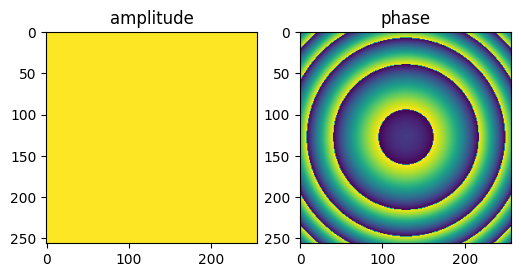

In [2]:
amp, phase, aperture = focusing_lens(
    in_size=[257,257],
    in_dx_m=[300e-9, 300e-9],
    wavelength_set_m=[600e-9],
    depth_set_m=[1e-3],
    fshift_set_m=[[0.0, 0.0]],
    out_distance_m=1e-3,
    aperture_radius_m=None,
    radial_symmetry=False
)
# returns focusing profiles of shape [Z, Lam, H, W]
print(amp.shape, phase.shape, aperture.shape)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(amp[0]*aperture[0], vmin=0, vmax=1)
ax[0].set_title("amplitude")
ax[1].imshow(phase[0])
ax[1].set_title("phase");

Running optimization with device cuda
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Loss: 0.1864: 100%|██████████| 500/500 [00:06<00:00, 76.78it/s]       


Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


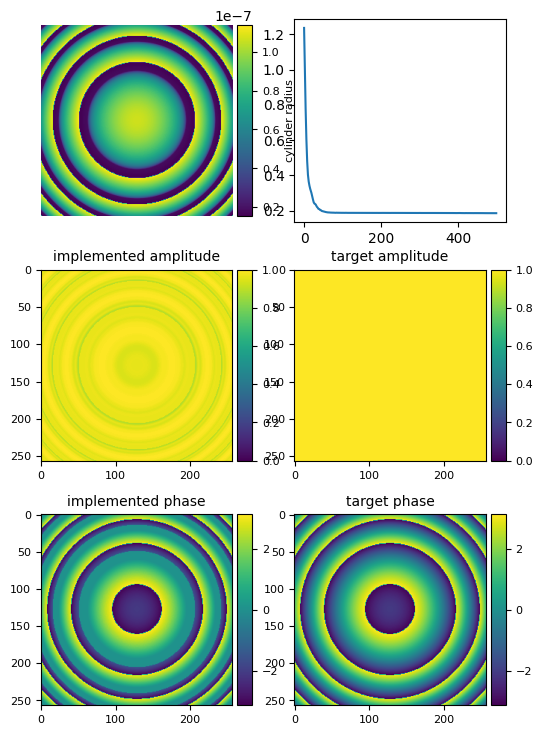

In [3]:
# Reverse look-up to find the metasurface that implements the target profile
model_name = "Nanocylinders_TiO2_U300H600"

p_norm, p, err = reverse_lookup_optimize(
    amp[None,None],
    phase[None,None],
    [600e-9],
    model_name,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,
    opt_phase_only=False)

# As a check, lets call the optical model and see what this metasurface does vs what we desired
model = load_optical_model(model_name)
model = model.to("cuda")

est_amp, est_phase = model(p, np.array([600e-9]), pre_normalized=False)
est_amp = est_amp.detach().cpu().numpy()
est_phase = est_phase.detach().cpu().numpy()

fig, ax = plt.subplots(3,2, figsize=(6,9))
ax[0,0].imshow(p.squeeze())
mp_format.format_plot(fig, ax[0,0], addcolorbar=True, setAspect="equal", cbartitle="cylinder radius")
ax[0,0].axis('off')
ax[0,1].plot(err)
ax[1,0].imshow(est_amp.squeeze(), vmin=0, vmax=1)
mp_format.format_plot(fig, ax[1,0], title="implemented amplitude", addcolorbar=True, setAspect="equal")
ax[1,1].imshow(amp.squeeze(), vmin=0, vmax=1)
mp_format.format_plot(fig, ax[1,1], title="target amplitude",  addcolorbar=True, setAspect="equal")
ax[2,0].imshow(est_phase.squeeze())
mp_format.format_plot(fig, ax[2,0], title="implemented phase", addcolorbar=True, setAspect="equal")
ax[2,1].imshow(phase.squeeze())
mp_format.format_plot(fig, ax[2,1], title="target phase", addcolorbar=True, setAspect="equal")

In [4]:
# Compute the point-spread function for this lens for different conditions
PSF = PointSpreadFunction(
    in_size=[257, 257],
    in_dx_m=[300e-9, 300e-9],
    out_distance_m=1e-3,
    out_size=[512, 512],
    out_dx_m=[500e-9, 500e-9],
    out_resample_dx_m=None,
    radial_symmetry=False,
    diffraction_engine="ASM")

ps_locs = [[0.0, 0.0, 5e-4], [0.0, 0.0, 1e-3], [0.0, 0.0, 5e-3]]
sim_wl = [500e-9, 600e-9, 700e-9]

intensity, phase = PSF(
    torch.tensor(est_amp, dtype=torch.float32, device='cuda'),
    torch.tensor(est_phase, dtype=torch.float32, device='cuda'),
    sim_wl,
    ps_locs,
    aperture=None,
    normalize_to_aperture=True)
intensity = intensity.cpu().numpy()
phase = phase.cpu().numpy()

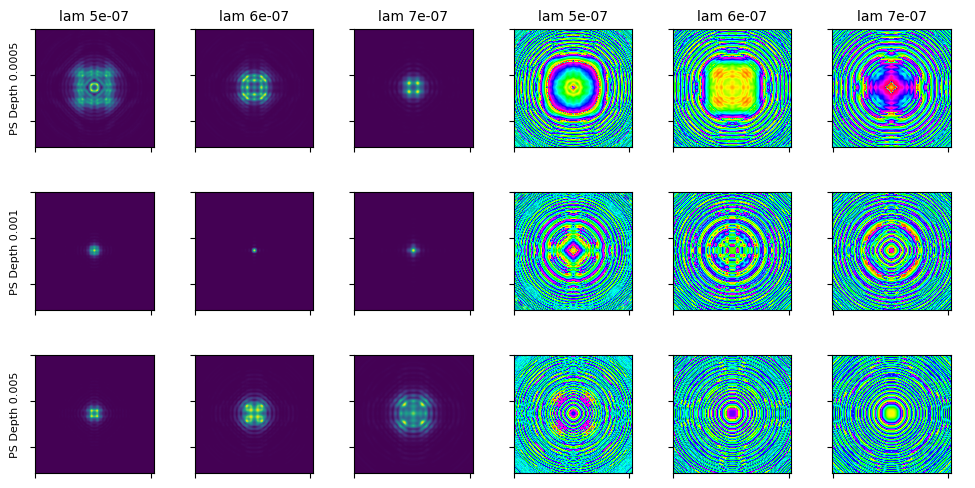

In [5]:
fig, ax = plt.subplots(3, 6, figsize=(12,6))
for z in range(3):
    for l in range(3):
        ax[z,l].imshow(intensity[0,0, z, l,:,:])
        mp_format.format_plot(
            fig, 
            ax[z,l],
            title= f"lam {sim_wl[l]}" if z==0 else "",
            rmvxLabel=True,
            rmvyLabel=True, 
            setAspect="equal")
        
    for l in np.arange(3,6,1):
        ax[z,l].imshow(phase[0,0, z, l-3,:,:], cmap='hsv')
        mp_format.format_plot(
            fig, 
            ax[z,l],
            title= f"lam {sim_wl[l-3]}" if z==0 else "",
            rmvxLabel=True,
            rmvyLabel=True, 
            setAspect="equal")
    ax[z,0].set_ylabel(f"PS Depth {ps_locs[z][2]}")

In [6]:
# Write this lens to a gds file for fabrication
pfab = p.squeeze(0)
mask = np.ones(pfab.shape[0:2])
cell_size = [300e-9, 300e-9]
block_size =[300e-9, 300e-9] # This can be used to repeat the cell as a larger block

from dflat.GDSII.assemble import assemble_nanocylinder_gds
assemble_nanocylinder_gds(pfab, mask, cell_size, block_size, savepath="./file.gds")

Writing metasurface shapes to GDS File


  0%|          | 0/257 [00:00<?, ?it/s]

100%|██████████| 257/257 [00:02<00:00, 128.09it/s]


Completed writing and saving metasurface GDS File: Time:  2.311383008956909


## Explore some image rendering with metasurfaces

In [7]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [8]:
import matplotlib.pyplot as plt
import mat73
from scipy import interpolate
import numpy as np
import torch
from einops import rearrange

from dflat.initialize import focusing_lens
from dflat.metasurface import reverse_lookup_optimize, load_optical_model
from dflat.propagation.propagators_legacy import PointSpreadFunction # Using the legacy version as it takes wavelength as a forward input instead of initialization input
from dflat.render import hsi_to_rgb
from dflat.plot_utilities import format_plot
from dflat.render import Fronto_Planar_Renderer_Incoherent

In [9]:
settings = {
    "in_size": [513, 513],
    "in_dx_m": [10*300e-9, 10*300e-9],
    "wavelength_set_m": [550e-9],
    "depth_set_m": [1e-2],
    "fshift_set_m": [[0.0, 0.0]],
    "out_distance_m": 1e-2,
    "aperture_radius_m": None,
    "radial_symmetry": True
    }
amp, phase, aperture = focusing_lens(**settings)
print(amp.shape, phase.shape, aperture.shape)
#  Phase, and Aperture profiles of shape [Z, Lam, H, W]

# Reverse look-up to find the metasurface that implements the target profile
model_name = "Nanocylinders_TiO2_U300H600"
p_norm, p, err = reverse_lookup_optimize(
    amp[None, None],
    phase[None, None],
    [550e-9],
    model_name,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,
    opt_phase_only=False)
print(p.shape)
# [B, H, W, D] where D is the number of shape parameters. 

# Predict the broadband phase and amplitude imparted by this collection of meta-atoms
model = load_optical_model(model_name)
model = model.to("cuda")
sim_wl = np.linspace(400e-9, 700e-9, 31)
est_amp, est_phase = model(p, sim_wl, pre_normalized=False)
print(est_amp.shape, est_phase.shape) 
# [B, pol, Lam, H, W] where pol is 1 or 2

# Compute the point spread function given this broadband stack of field amplitude and phases
PSF = PointSpreadFunction(
    in_size=[513, 513],
    in_dx_m=[10*300e-9, 10*300e-9],
    out_distance_m=1e-2,
    out_size=[512, 512],
    out_dx_m=[5e-6,5e-6],
    out_resample_dx_m=None,
    radial_symmetry=True,
    diffraction_engine="ASM")
ps_locs = [[0.0, 0.0, 1e-2]]

psf_intensity, _ = PSF(
    est_amp.to(dtype=torch.float32, device='cuda'),
    est_phase.to(dtype=torch.float32, device='cuda'),
    sim_wl,
    ps_locs,
    aperture=None,
    normalize_to_aperture=True)
print(psf_intensity.shape)
# shape [B P Z L H W]

(1, 1, 257) (1, 1, 257) (1, 1, 257)
Running optimization with device cuda
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Loss: 0.1220: 100%|██████████| 500/500 [00:02<00:00, 241.85it/s]


(1, 1, 257, 1)
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys
torch.Size([1, 1, 31, 1, 257]) torch.Size([1, 1, 31, 1, 257])
torch.Size([1, 1, 1, 31, 512, 512])


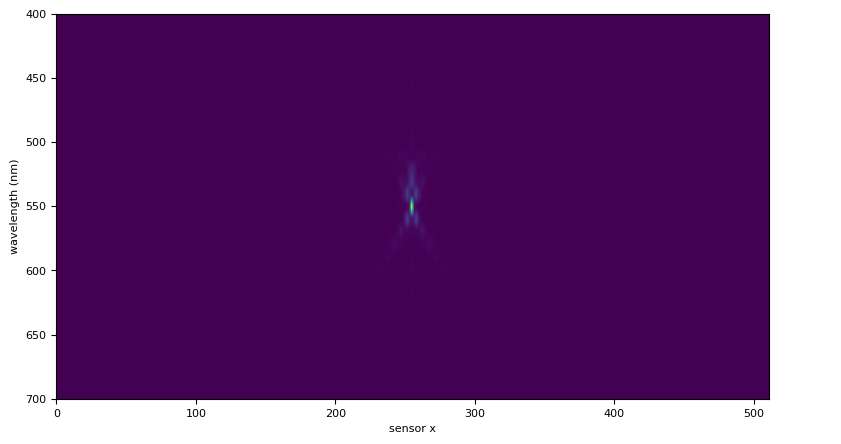

In [10]:
# Display a slice of the radially symmetric point-spread function we will use
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow(psf_intensity[0,0,0,:,256,:].detach().cpu().numpy())
format_plot(fig, ax, ylabel="wavelength (nm)", xlabel="sensor x", yvec=sim_wl*1e9, xvec = np.arange(0,512,1), setAspect="auto")


(482, 512, 31) (482, 512, 3)


Text(0.5, 1.0, 'HSI Projected to RGB')

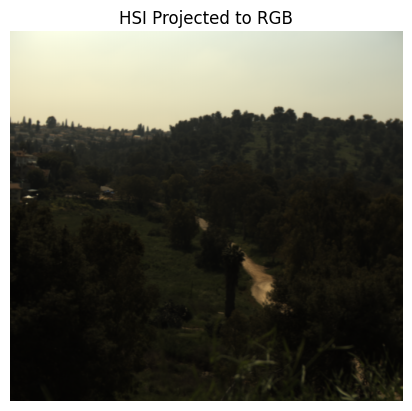

In [11]:
# Load a hyperspectral image for rendering

def load_mat_dat(path):
    # Note: not sure what norm_factor is used for
    # Investigate or in the future add a note once identified
    # Upon inspection, bands are provided in units of nm and range from 400 to 700 nm for Arad1k
    # with a 10 nm step size
    mat_dat = mat73.loadmat(path)
    bands = mat_dat["bands"]
    cube = mat_dat["cube"]
    _ = mat_dat["norm_factor"]
    return bands, cube


def interpolate_HS_Cube(new_channels_nm, hs_cube, hs_bands):
    # Throw an error if we try to extrapolate
    if (min(new_channels_nm) < min(hs_bands) - 1) or (
        max(new_channels_nm) > max(hs_bands) + 1
    ):
        raise ValueError(
            f"In generator, extrapoaltion of the ARAD dataset outside of measurement data is not allowed: {min(hs_bands)}-{max(hs_bands)}"
        )

    interpfun = interpolate.interp1d(
        hs_bands,
        hs_cube,
        axis=-1,
        kind="linear",
        assume_sorted=True,
        fill_value="extrapolate",
        bounds_error=False,
    )
    resampled = interpfun(new_channels_nm)

    return resampled

# Load hyperspectral data cube needed for rendering
sim_wl = np.linspace(400e-9, 700e-9, 31)
bands, cube = load_mat_dat("./ARAD_1K_0001.mat")
hsi_data = interpolate_HS_Cube(sim_wl*1e9, cube, bands)
hsi_data = np.clip(hsi_data, 0, 1)
rgb_img = hsi_to_rgb(hsi_data[None], sim_wl)[0]
print(hsi_data.shape, rgb_img.shape)

fig, ax  = plt.subplots(1,1)
ax.imshow(rgb_img)
ax.axis('off')
ax.set_title("HSI Projected to RGB")

torch.Size([1, 1, 1, 31, 512, 512]) torch.Size([1, 1, 1, 31, 482, 512])
torch.Size([1, 1, 1, 3, 482, 512]) torch.Size([1, 1, 1, 1, 482, 512])


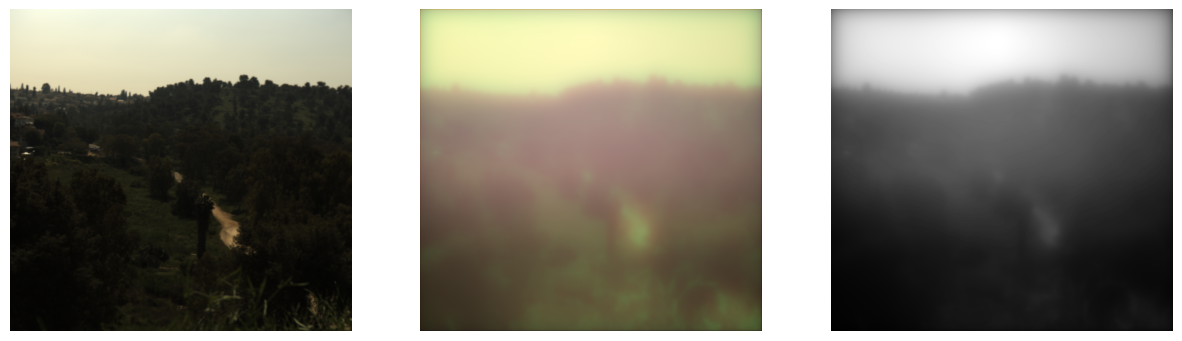

In [12]:
renderer = Fronto_Planar_Renderer_Incoherent()
# Need to pass inputs like
# psf has shape  [B P Z L H W]
# scene radiance [1 P Z L H W]
hsi_cube = rearrange(hsi_data, "H W C -> C H W")[None, None, None]
hsi_cube = torch.tensor(hsi_cube, dtype=torch.float32, device='cuda')
psf_intensity = psf_intensity.to('cuda')
print(psf_intensity.shape, hsi_cube.shape)

out_int = renderer(psf_intensity, hsi_cube, rfft=True, crop_to_psf_dim=False)
meas_rgb = renderer.rgb_measurement(out_int, sim_wl, gamma=True, bayer_mosaic=True)
meas_gs = torch.sum(out_int, -3, keepdim=True)
print(meas_rgb.shape, meas_gs.shape)

# Displayed the RGB measurement after the metasurface
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(rgb_img)
ax[1].imshow(np.transpose(meas_rgb[0,0,0].detach().cpu().numpy(), [1,2,0]))
ax[2].imshow(meas_gs[0,0,0,0].detach().cpu().numpy(), cmap='gray')
[axi.axis('off') for axi in ax.flatten()];


The image is blurry? Yes because metasurfaces by themselves are high chromatic. You have chromatic dispersion.
Dflat can be used to optimize metasurfaces with gradient descent to minimize dispersion or can be used alongside post-processing algorithms to learn to deblurr these images and restore high quality images or reconstruct properties of the scene like depth and hyperspectral information. 

Tutorials on this will be made in the future
